In [1]:
#imports

from PIL import Image
import os
from pathlib import Path
import argparse
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report

from one_g import WT3Net,WaterLevelDataset,ToTensor


/var/folders/s9/7x6wjtq126773lhfsl5rqqv40000gn/T/ipykernel_20350/2398708771.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH)

Filename : deploy/split2test/t5frame001.jpg


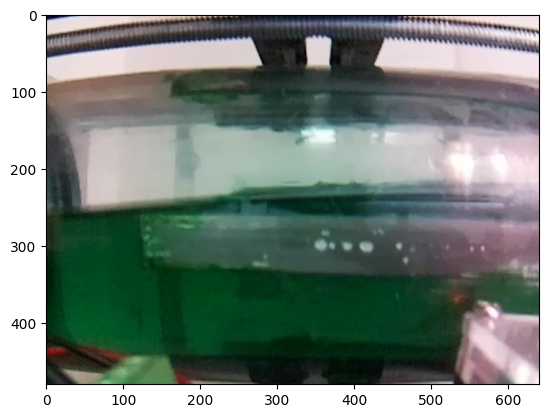

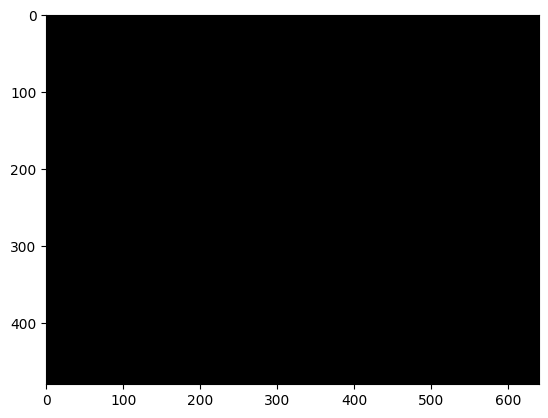

Filename : deploy/split2test/t5frame002.jpg


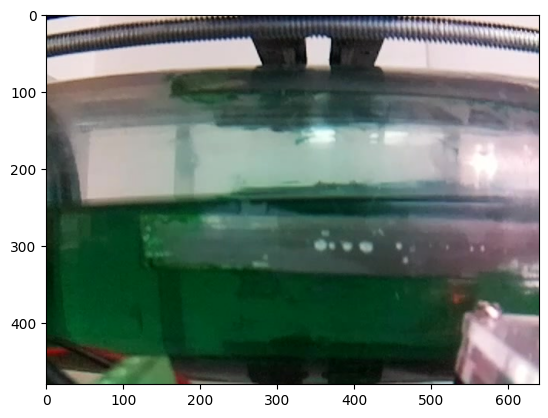

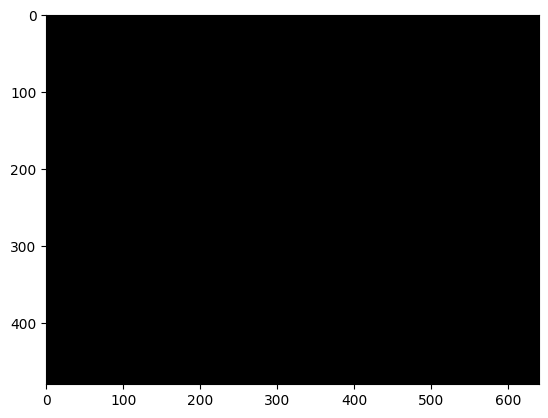

Filename : deploy/split2test/t5frame003.jpg


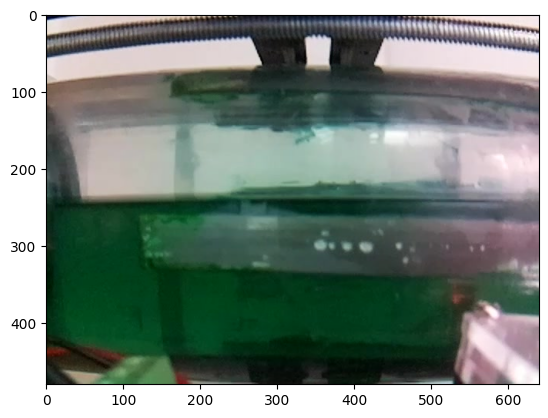

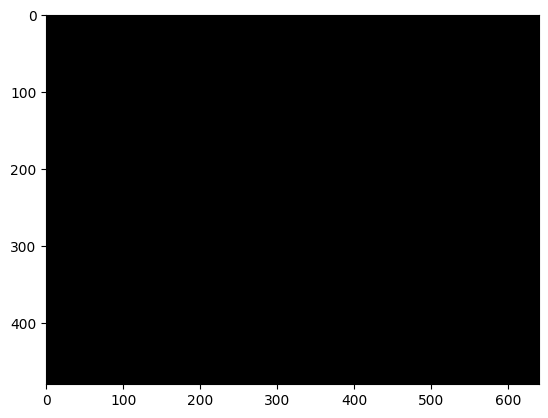

Filename : deploy/split2test/t5frame007.jpg


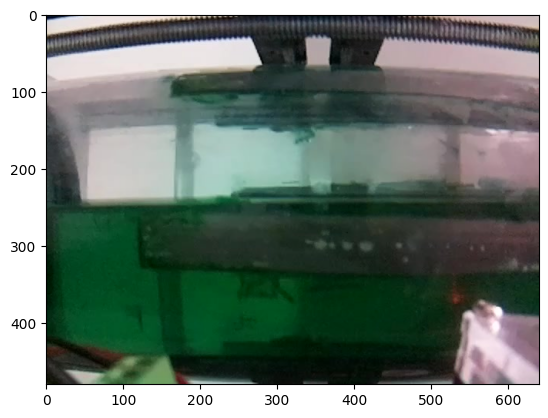

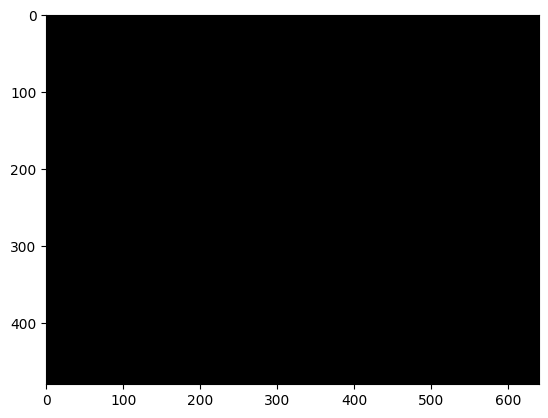

Filename : deploy/split2test/t5frame006.jpg


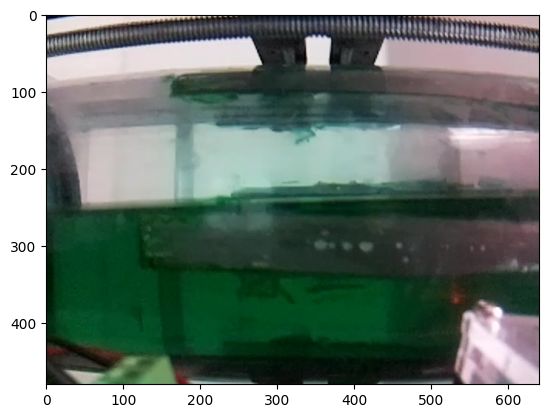

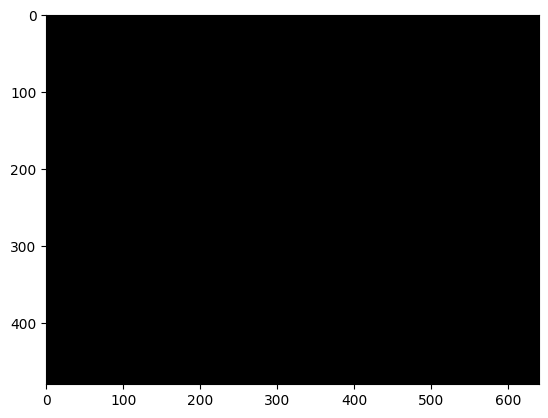

Filename : deploy/split2test/t5frame010.jpg


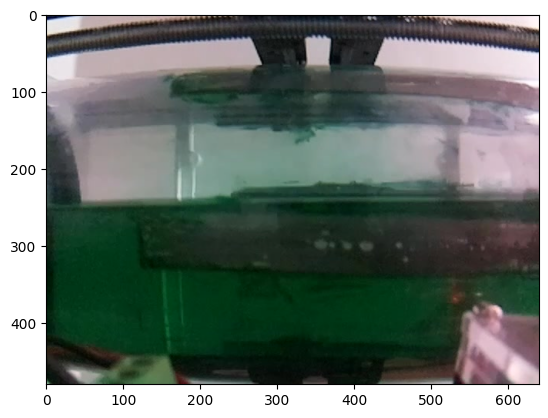

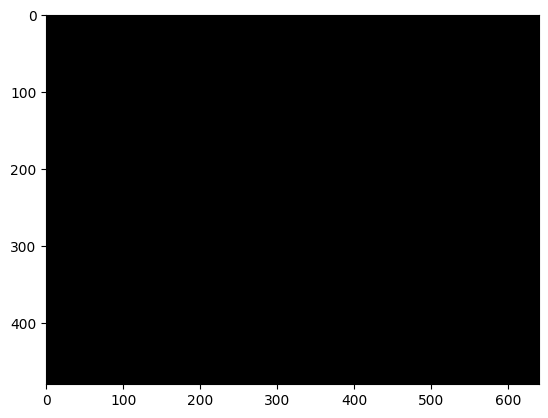

Filename : deploy/split2test/t5frame004.jpg


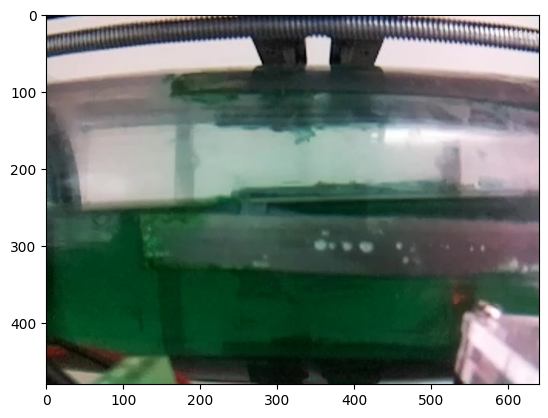

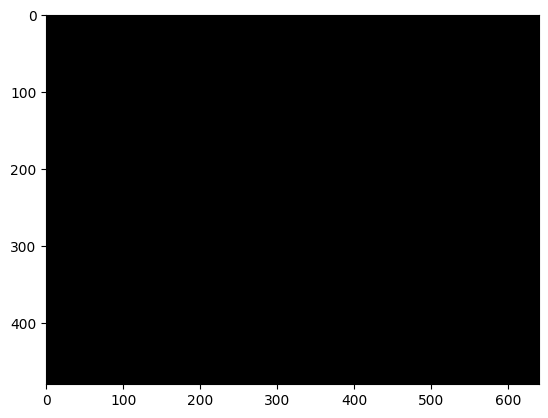

Filename : deploy/split2test/t5frame005.jpg


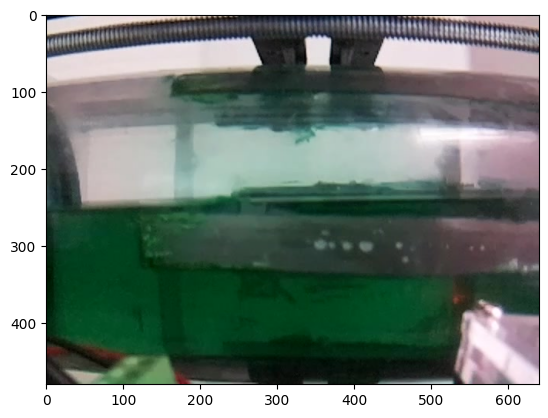

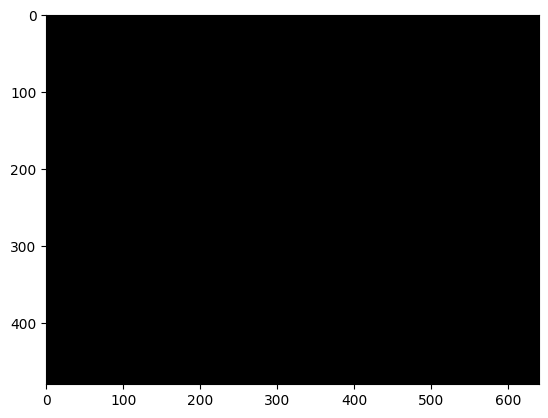

Filename : deploy/split2test/t4frame009.jpg


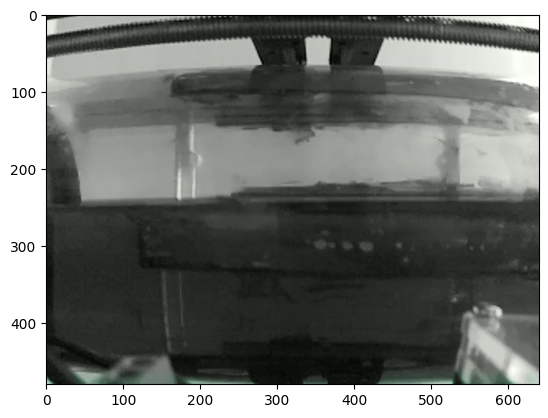

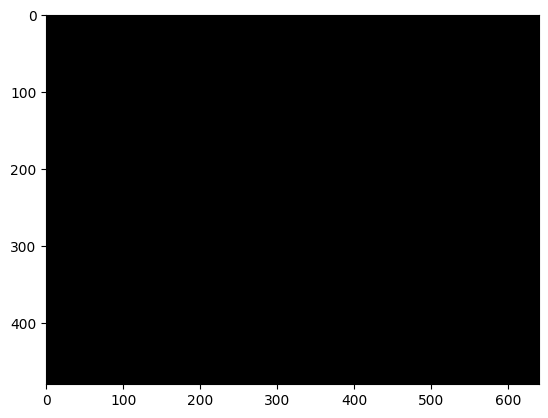

Filename : deploy/split2test/t4frame008.jpg


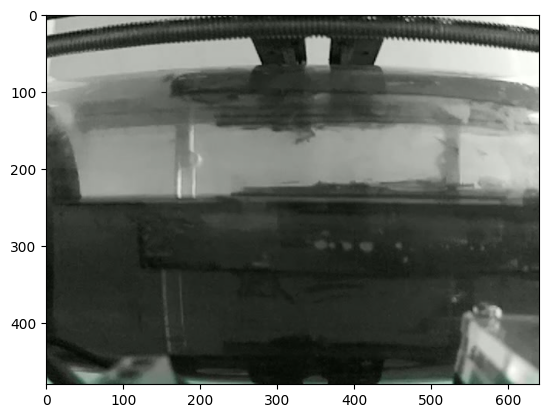

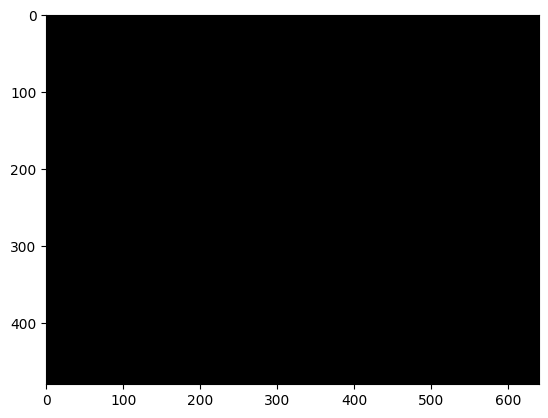

Filename : deploy/split2test/t4frame005.jpg


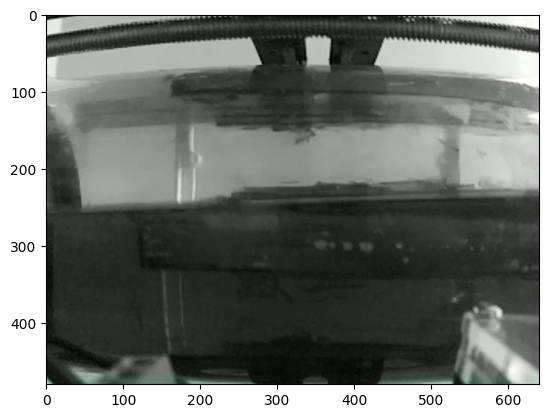

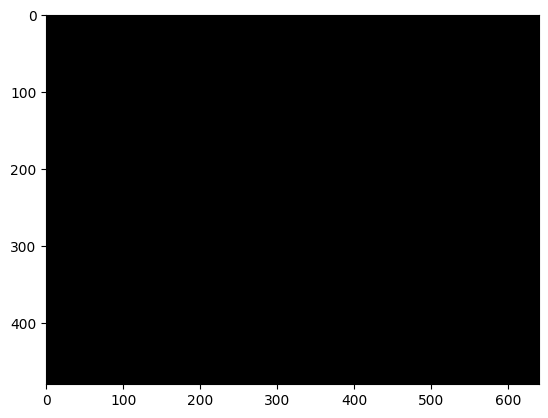

Filename : deploy/split2test/t4frame004.jpg


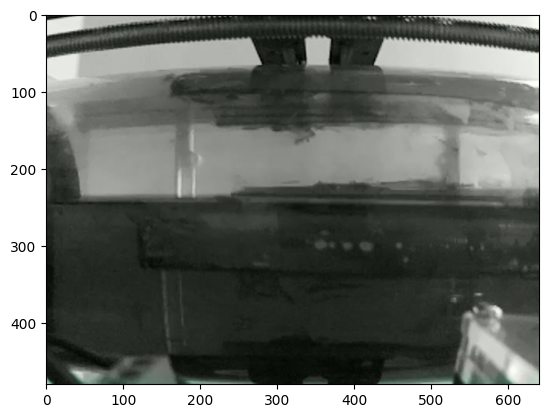

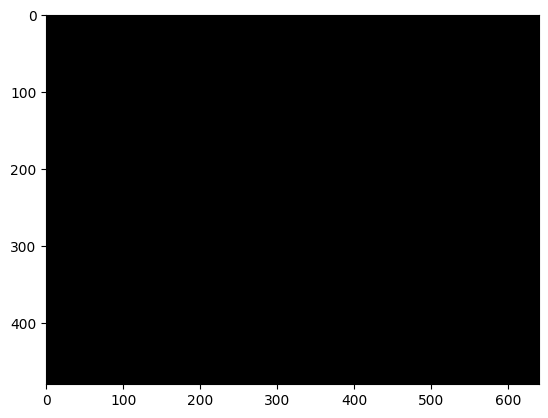

Filename : deploy/split2test/t4frame010.jpg


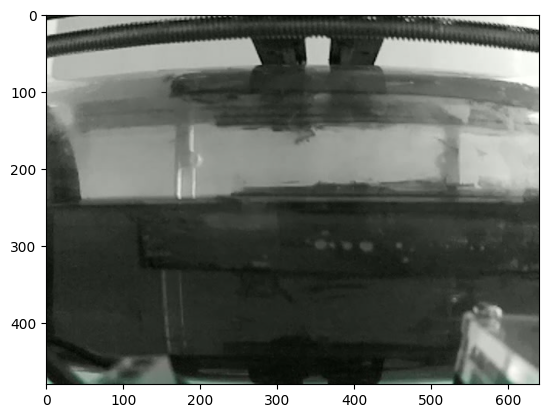

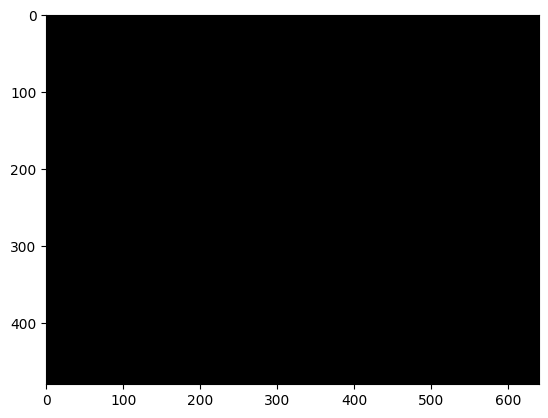

Filename : deploy/split2test/t4frame006.jpg


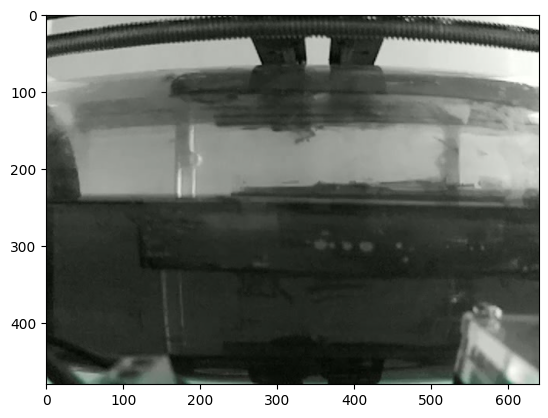

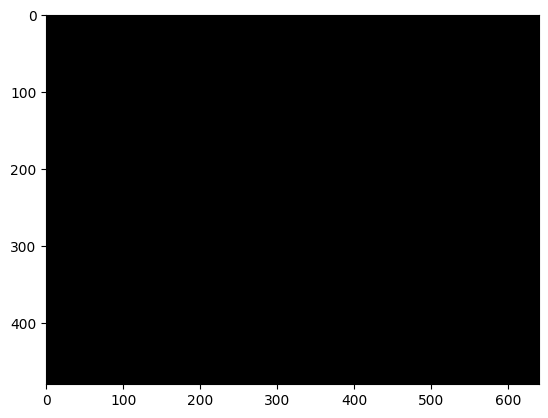

Filename : deploy/split2test/t4frame007.jpg


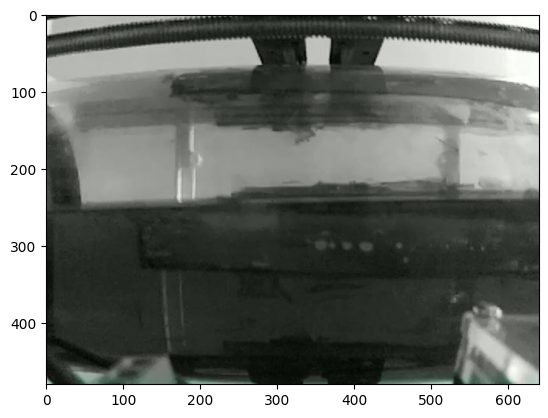

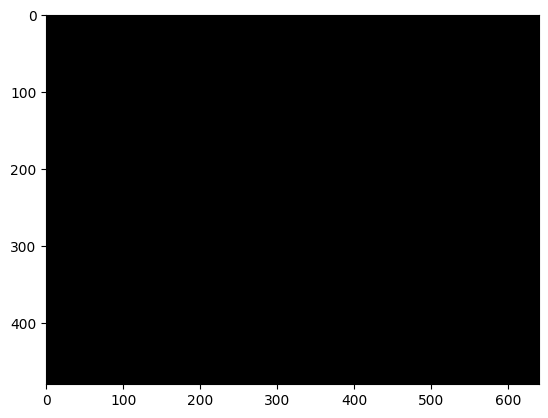

Filename : deploy/split2test/t4frame003.jpg


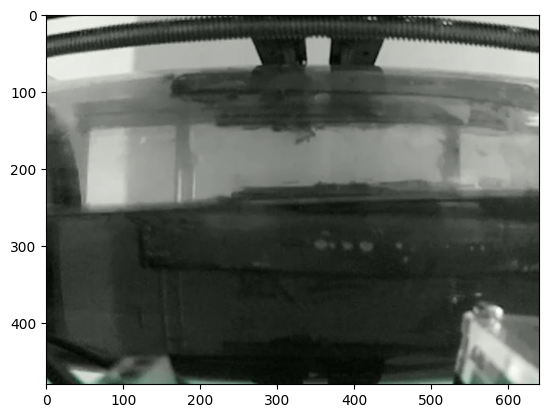

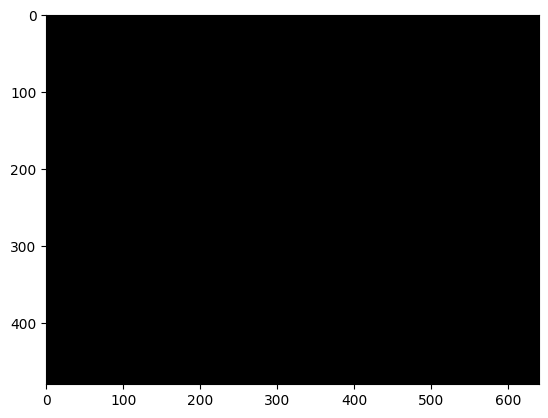

Filename : deploy/split2test/t4frame002.jpg


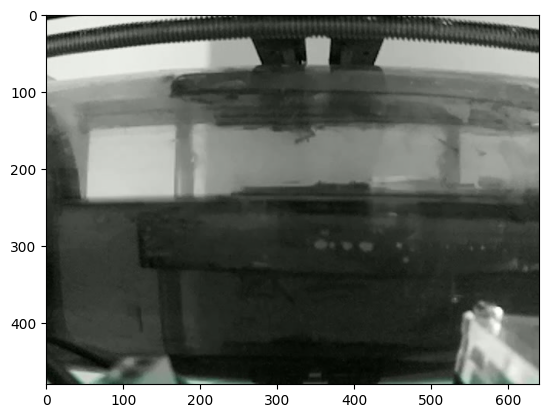

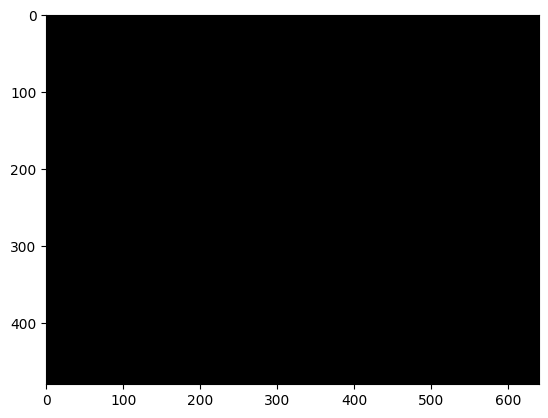

Filename : deploy/split2test/t4frame001.jpg


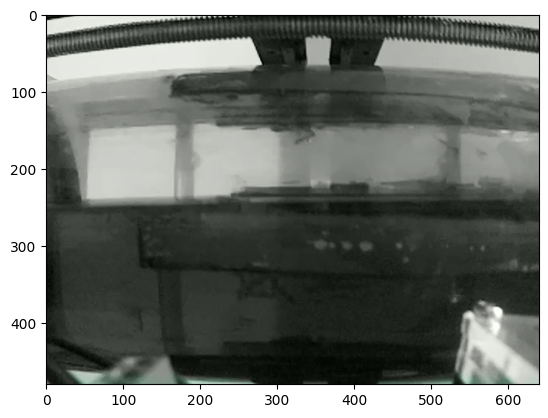

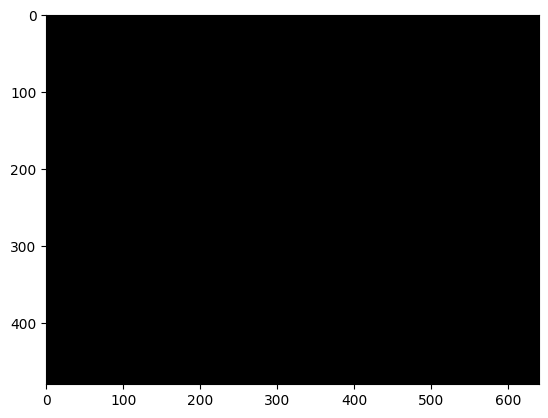

Filename : deploy/split2test/t5frame008.jpg


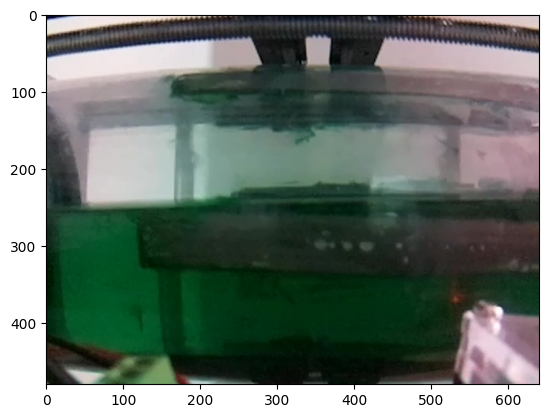

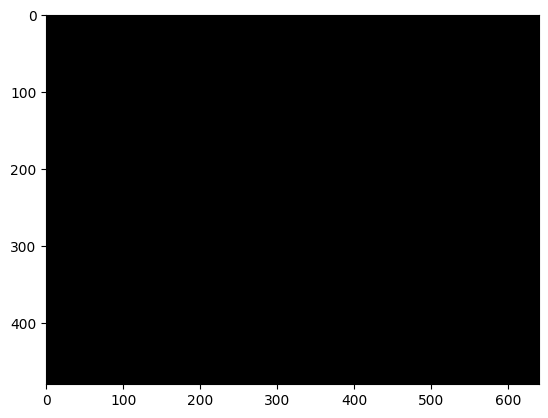

Filename : deploy/split2test/t5frame009.jpg


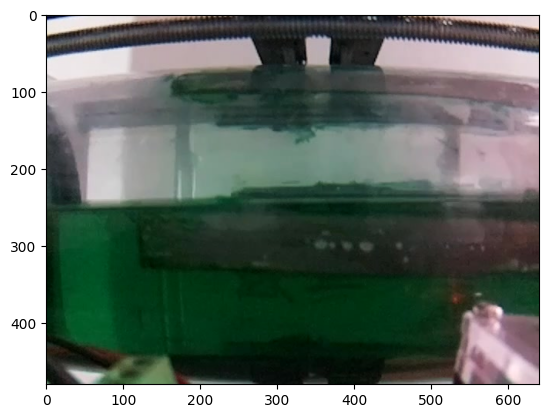

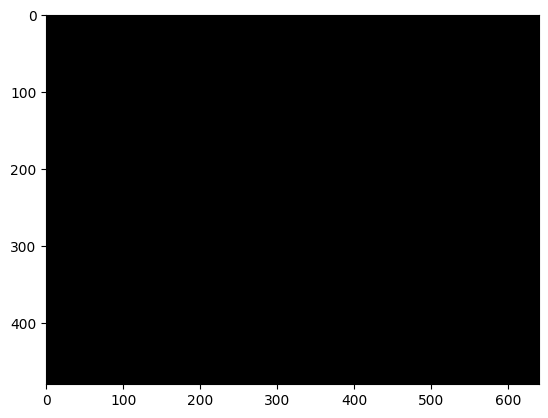

In [4]:
DEPLOY_INPUT_DIR='deploy/split2test'
DEPLOY_OUTPUT_DIR='deploy/split2out'
MODEL_PATH = 'data/exps/default_exp/model.pt'

os.makedirs(DEPLOY_OUTPUT_DIR,exist_ok=True)

filenames = [os.path.join(DEPLOY_INPUT_DIR,_) for _ in os.listdir(DEPLOY_INPUT_DIR)
           if os.path.isfile(os.path.join(DEPLOY_INPUT_DIR,_)) and _.endswith('.jpg')]

d_imgs,d_ann_imgs = [],[]
for f_ in filenames:
  original = Image.open(f_)
  original = np.asarray(original)
  original = original[:,:,:3]
  
  # Dummy annotation mask, to ensure we only need one Dataset class.
  annotation_mask = np.zeros(original.shape[:2])

  d_imgs.append(original)
  d_ann_imgs.append(annotation_mask)

model = WT3Net(num_channels = 10, filter_size = 7)
model.load_state_dict(torch.load(MODEL_PATH))

transform = ToTensor()


deploy_dataset = WaterLevelDataset(d_imgs,d_ann_imgs,transform = transform)

T = 1e-1
for idx in range(deploy_dataset.__len__()):
  dta = deploy_dataset[idx]
  inputs = dta['input'] 
  targets = dta['target']

  img = inputs.cpu().detach().numpy().transpose((1,2,0))
  outp = F.softmax((model(inputs)/T),dim = 0).cpu().detach().numpy()


  img[:,:,0] +=outp
  img[:,:,0] = img[:,:,0]/img[:,:,0].max()
  base_filename = os.path.basename(filenames[idx])
  print(f'Filename : {filenames[idx]}')
  plt.imshow(img)
  plt.show()
  plt.imsave(os.path.join(DEPLOY_OUTPUT_DIR,f'out_{base_filename}'),img)

  outp = F.softmax(model(inputs),dim = 0).cpu().detach().numpy()
  plt.imsave(os.path.join(DEPLOY_OUTPUT_DIR,f'out_gray_{base_filename}'),outp,cmap='gray')
  plt.imshow(outp,cmap='gray')
  plt.show()

